In [41]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier  
import re
import tensorflow as tf
from sklearn.tree._tree import TREE_LEAF

In [58]:
def print_result(y_real, y_predicted):
    cm = confusion_matrix(y_real.argmax(axis=1), y_predicted.argmax(axis=1))
    ax = plt.subplot()
    sn.heatmap(cm, annot=True, fmt="g", ax=ax)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(["1", "2", "3", "4", "5"])
    ax.yaxis.set_ticklabels(["1", "2", "3", "4", "5"])
    plt.show()

    print("Accuracy is ", accuracy_score(y_real, y_predicted))
    print("F1 Score is ", f1_score(y_real, y_predicted, average="macro"))
    print("Precision is ", precision_score(y_real, y_predicted, average="macro"))
    print("Recall is ", recall_score(y_real, y_predicted, average="macro"))
    print(classification_report(y_real, y_predicted))

In [54]:
def print_roc(y_test, y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(30, 6))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
    plt.show()

In [10]:
def get_corr_matrix(df):
    corrMatrix = df.corr()
    plt.figure(figsize=(20, 10))
    sn.heatmap(corrMatrix, xticklabels=corrMatrix.columns, yticklabels=corrMatrix.columns, annot=True)
    plt.show()

In [11]:
def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)


In [12]:
df = pd.read_csv("data.csv", encoding="utf-16")
df.head()

,id,book,writer,publisher,num_pages,num_comments,num_favorites,num_will_read,num_is_read,num_did_read,...,num_five_star,num_four_star,num_three_star,num_two_star,num_one_star,comment,price,type,star,positivity
0,582550,Gece Yarısı Kütüphanesi,Matt Haig,DOMİNGO YAYINEVİ,283,782,25645,2,361,2,...,959,174,86,22,26,"['son', 'zamanlarda', 'nora', 'kovulup', 'kedi...",48.11,Roman (çeviri),5,0.320376
1,582550,Gece Yarısı Kütüphanesi,Matt Haig,DOMİNGO YAYINEVİ,283,782,25645,2,361,2,...,959,174,86,22,26,"['milyonlarca', 'ihtiva', 'kimi', 'kimi', 'fak...",48.11,Roman (çeviri),5,0.641740
2,582550,Gece Yarısı Kütüphanesi,Matt Haig,DOMİNGO YAYINEVİ,283,782,25645,2,361,2,...,959,174,86,22,26,"['kimi', 'zaman', 'genclik', 'gibi', 'kimi', '...",48.11,Roman (çeviri),5,0.082714
3,582550,Gece Yarısı Kütüphanesi,Matt Haig,DOMİNGO YAYINEVİ,283,782,25645,2,361,2,...,959,174,86,22,26,"['bu', 'kadar', 'basit', 'fakat', 'mesajlar', ...",48.11,Roman (çeviri),5,0.753227
4,582550,Gece Yarısı Kütüphanesi,Matt Haig,DOMİNGO YAYINEVİ,283,782,25645,2,361,2,...,959,174,86,22,26,"['ve', 'hikayesiyle', 'okuyucuyu', 'kendine', ...",48.11,Roman (çeviri),5,0.962527


In [13]:
df.book.value_counts()

Altıncı Koğuş               99
Suç ve Ceza                 97
Şeker Portakalı             95
Hayvan Çiftliği             92
Tiamat                      62
                            ..
Bu Beden Benim Evim          1
Sana Bağımlı                 1
Uzak Dağlar ve Hatıralar     1
Galateia: Bir Öykü           1
Gothikana                    1
Name: book, Length: 947, dtype: int64

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,35964.0,353107.803748,218654.075093,46.000000,92811.000000,427204.00000,551120.000000,634155.000000
num_pages,35964.0,275.875570,165.856347,28.000000,152.000000,240.00000,361.000000,1515.000000
num_comments,35964.0,198.636915,225.175494,1.000000,42.000000,109.00000,281.000000,981.000000
num_favorites,35964.0,5551.626877,6559.035149,21.000000,1931.000000,3937.00000,6921.000000,56787.000000
num_will_read,35964.0,242.855494,216.609401,1.000000,84.000000,176.00000,349.000000,998.000000
num_is_read,35964.0,49.485986,91.785470,0.000000,10.000000,22.00000,50.000000,936.000000
num_did_read,35964.0,242.299160,249.330385,1.000000,44.000000,159.50000,373.000000,979.000000
num_purchases,35964.0,10992.065788,23517.428387,50.000000,2617.000000,5392.00000,9748.000000,273148.000000
num_ratings,35964.0,825.755895,2006.451573,1.000000,124.000000,289.00000,775.000000,23803.000000
avg_rating,35964.0,92.817048,3.813114,60.000000,91.300000,93.70000,95.200000,100.000000


In [15]:
df.drop(["id", "book", "writer", "publisher", "comment"], axis=1, inplace=True)
df.drop_duplicates(inplace=True)

In [16]:
df["avg_five_star"] = df.num_five_star / df.num_ratings
df["avg_four_star"] = df.num_four_star / df.num_ratings
df["avg_three_star"] = df.num_three_star / df.num_ratings
df["avg_two_star"] = df.num_two_star / df.num_ratings
df["avg_one_star"] = df.num_one_star / df.num_ratings
df["avg_comment"] = df.num_comments / df.num_ratings
df["did_read_by_favorites"] = df.num_did_read / df.num_favorites
df["did_read_by_favorites"] = df.did_read_by_favorites.apply(lambda x : 1.0 if x > 1.0 else x)

df["sum_reader"] = df.num_will_read + df.num_is_read + df.num_did_read
df["avg_will_read"] = df.num_will_read / df.sum_reader
df["avg_is_read"] = df.num_is_read / df.sum_reader
df["avg_did_read"] = df.num_did_read / df.sum_reader

df = pd.get_dummies(df, columns=["type"])

In [17]:
corr = df.corrwith(df["star"]).apply(lambda x : abs(x)).sort_values(ascending=True)
corr = corr[corr > 0.05]
corr = corr.to_dict().keys()

In [18]:
corr

dict_keys(['num_two_star', 'positivity', 'avg_one_star', 'avg_four_star', 'avg_two_star', 'avg_three_star', 'avg_five_star', 'avg_rating', 'star'])

In [19]:
df = df[corr]

In [20]:
df.star.value_counts()

5    19470
4     5089
3     1933
2      518
1      321
Name: star, dtype: int64

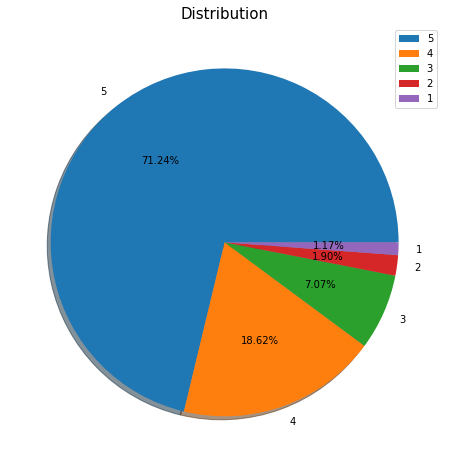

In [21]:
labels = ["5", "4", "3", "2", "1"]

figure, axes = plt.subplots(figsize=(8, 8))
axes.pie(df.star.value_counts().to_list(), labels=labels, shadow=True, autopct = "%1.2f%%")
plt.legend()
plt.title("Distribution", size = 15)
plt.show()

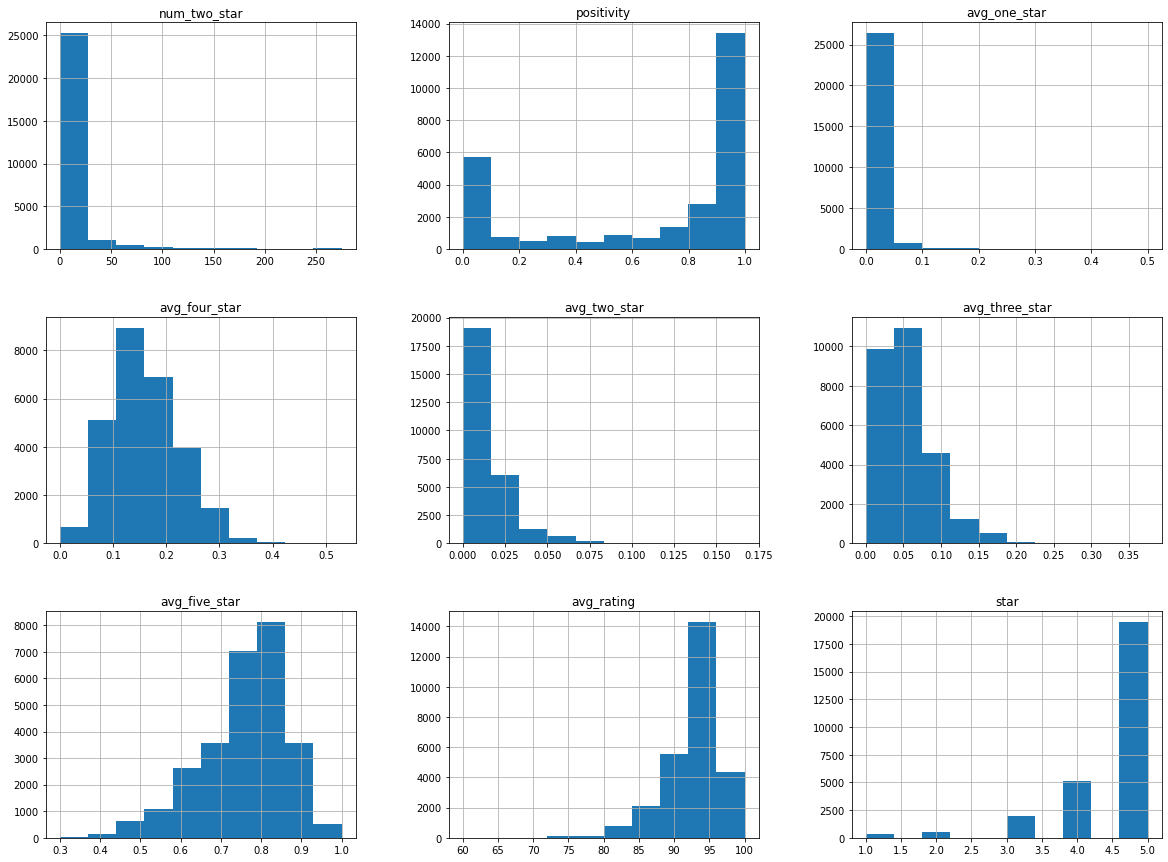

In [22]:
df.hist(figsize = (20,15))
plt.show()

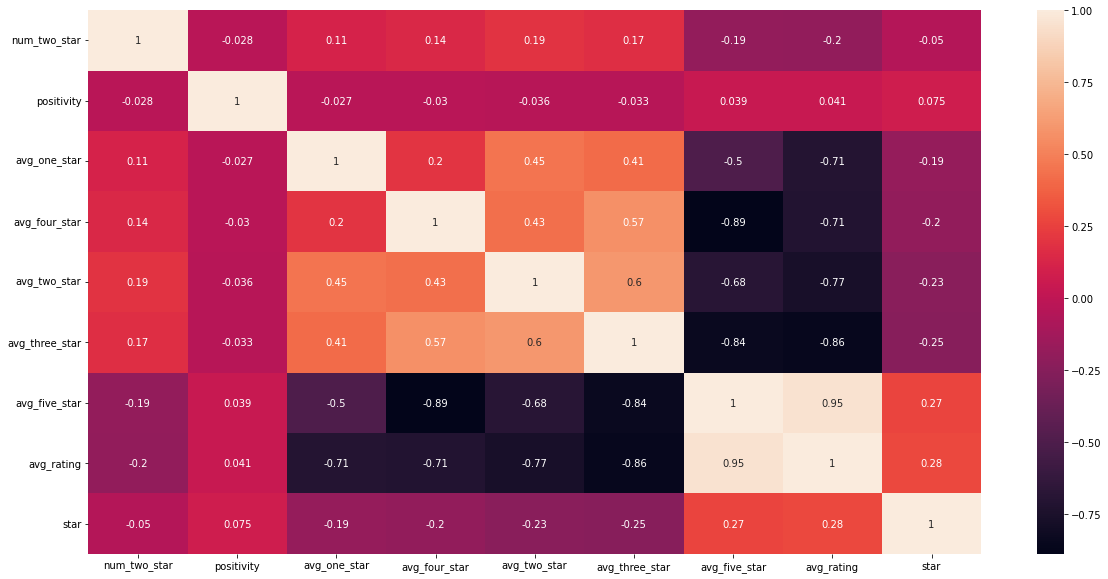

In [23]:
get_corr_matrix(df)

In [24]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.star)
train, validation = train_test_split(train, test_size=0.2, random_state=42, stratify=train.star)

X_train = train.drop(["star"], axis=1)
y_train = train.star
X_validation = validation.drop(["star"], axis=1)
y_validation = validation.star
X_test = test.drop(["star"], axis=1)
y_test = test.star

In [25]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_validation = onehot_encoder.fit_transform(y_validation.to_numpy().reshape(-1, 1))
y_test = onehot_encoder.fit_transform(y_test.to_numpy().reshape(-1, 1))

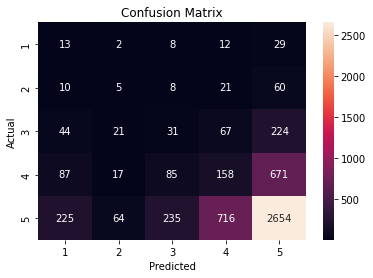

Accuracy is  0.5214925919151271
F1 Score is  0.20894228499600187
Precision is  0.2161806256521306
Recall is  0.20236458911272312
              precision    recall  f1-score   support

           0       0.06      0.05      0.05        64
           1       0.05      0.05      0.05       104
           2       0.08      0.08      0.08       387
           3       0.16      0.16      0.16      1018
           4       0.73      0.68      0.70      3894

   micro avg       0.55      0.52      0.54      5467
   macro avg       0.22      0.20      0.21      5467
weighted avg       0.56      0.52      0.54      5467
 samples avg       0.52      0.52      0.52      5467



c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print_result(y_test, y_pred_dt)

In [60]:
params = {"criterion": ["gini", "entropy"],
          "max_depth": [5, 6, 7, 8, 9, 10, 11, 12, None],
          "max_features": ["auto", "sqrt", "log2"]
          }
grid = GridSearchCV(estimator=dt, param_grid=params,
                    cv=10,  return_train_score=False, verbose=0, n_jobs=-1,
                    scoring="f1_macro")
grid.fit(X_validation, y_validation)
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto'}
0.21421445952768128


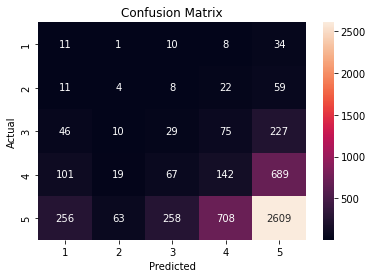

Accuracy is  0.5096030729833547
F1 Score is  0.19809935798231187
Precision is  0.2061337015639134
Recall is  0.1908282539168366
              precision    recall  f1-score   support

           0       0.04      0.03      0.04        64
           1       0.04      0.04      0.04       104
           2       0.08      0.07      0.08       387
           3       0.15      0.14      0.14      1018
           4       0.72      0.67      0.69      3894

   micro avg       0.55      0.51      0.53      5467
   macro avg       0.21      0.19      0.20      5467
weighted avg       0.55      0.51      0.53      5467
 samples avg       0.51      0.51      0.51      5467



c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
dt = DecisionTreeClassifier(**grid.best_params_, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print_result(y_test, y_pred_dt)

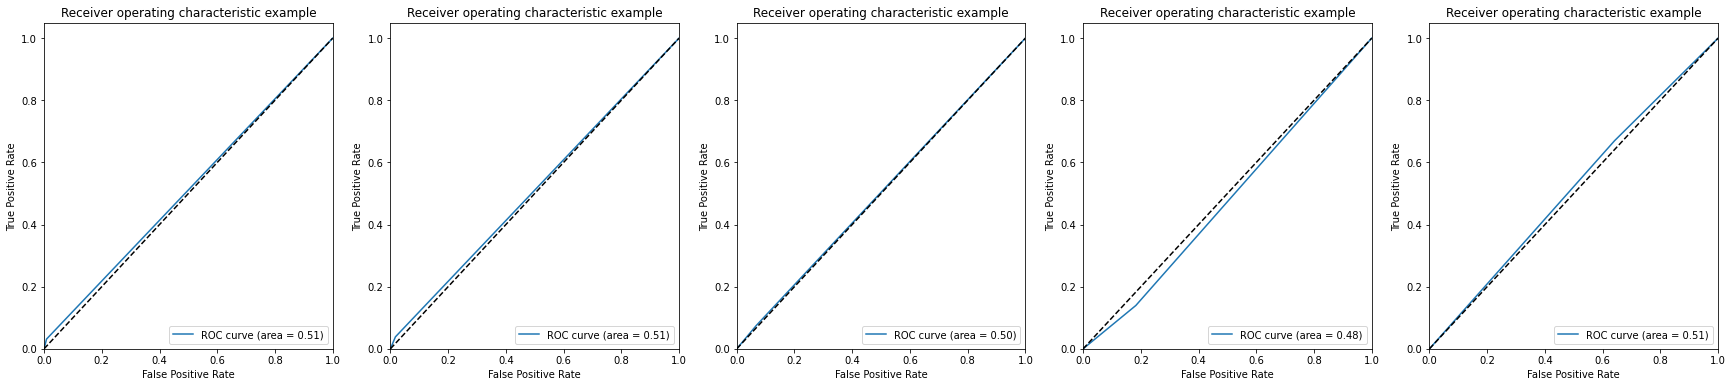

In [62]:
print_roc(y_test, y_pred_dt)

<AxesSubplot:>

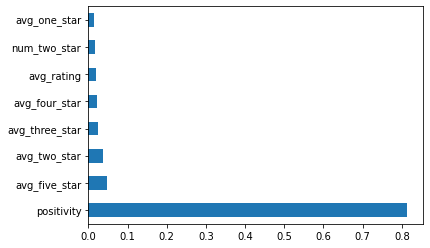

In [23]:
(pd.Series(dt.feature_importances_, index=X_train.columns)
.nlargest(10)
   .plot(kind="barh")) 

In [24]:
print(sum(dt.tree_.children_left < 0))
prune_index(dt.tree_, 0, 5)
sum(dt.tree_.children_left < 0)

8043


8139

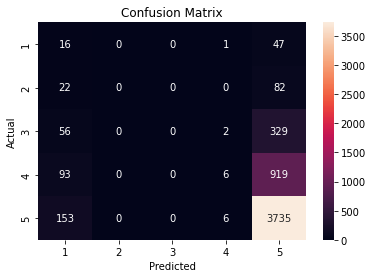

Accuracy is  0.684287543442473
F1 Score is  0.16821273716844465
Precision is  0.22612676056338027
Recall is  0.19301237206401872


c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
y_pred_dt = dt.predict(X_test)
print_result(y_test, y_pred_dt)

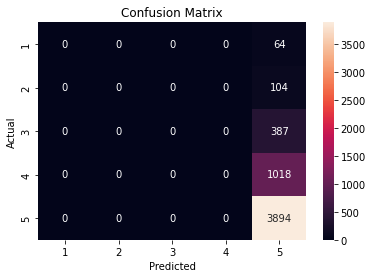

Accuracy is  0.7122736418511066
F1 Score is  0.1663924794359577
Precision is  0.14245472837022133
Recall is  0.2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.00      0.00      0.00       104
           2       0.00      0.00      0.00       387
           3       0.00      0.00      0.00      1018
           4       0.71      1.00      0.83      3894

   micro avg       0.71      0.71      0.71      5467
   macro avg       0.14      0.20      0.17      5467
weighted avg       0.51      0.71      0.59      5467
 samples avg       0.71      0.71      0.71      5467



c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
nb = OneVsRestClassifier(estimator=BernoulliNB(), n_jobs=-1)
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print_result(y_test, y_pred_nb)

In [64]:
params = {"estimator__alpha": [a*0.1 for a in range(0,11)]}

grid = GridSearchCV(estimator=nb, param_grid=params,
                    cv=10, scoring="f1_macro", return_train_score=False, verbose=0, n_jobs=-1)
grid.fit(X_validation, y_validation)
print(grid.best_params_)
print(grid.best_score_)

{'estimator__alpha': 0.0}
0.16637601889892467


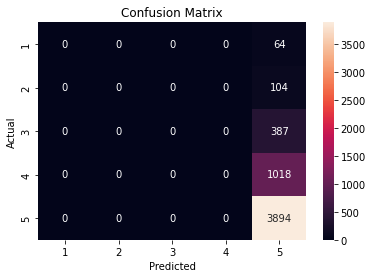

Accuracy is  0.7122736418511066
F1 Score is  0.1663924794359577
Precision is  0.14245472837022133
Recall is  0.2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.00      0.00      0.00       104
           2       0.00      0.00      0.00       387
           3       0.00      0.00      0.00      1018
           4       0.71      1.00      0.83      3894

   micro avg       0.71      0.71      0.71      5467
   macro avg       0.14      0.20      0.17      5467
weighted avg       0.51      0.71      0.59      5467
 samples avg       0.71      0.71      0.71      5467



c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
nb = OneVsRestClassifier(estimator=BernoulliNB(alpha=0.0), n_jobs=-1)
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print_result(y_test, y_pred_nb)

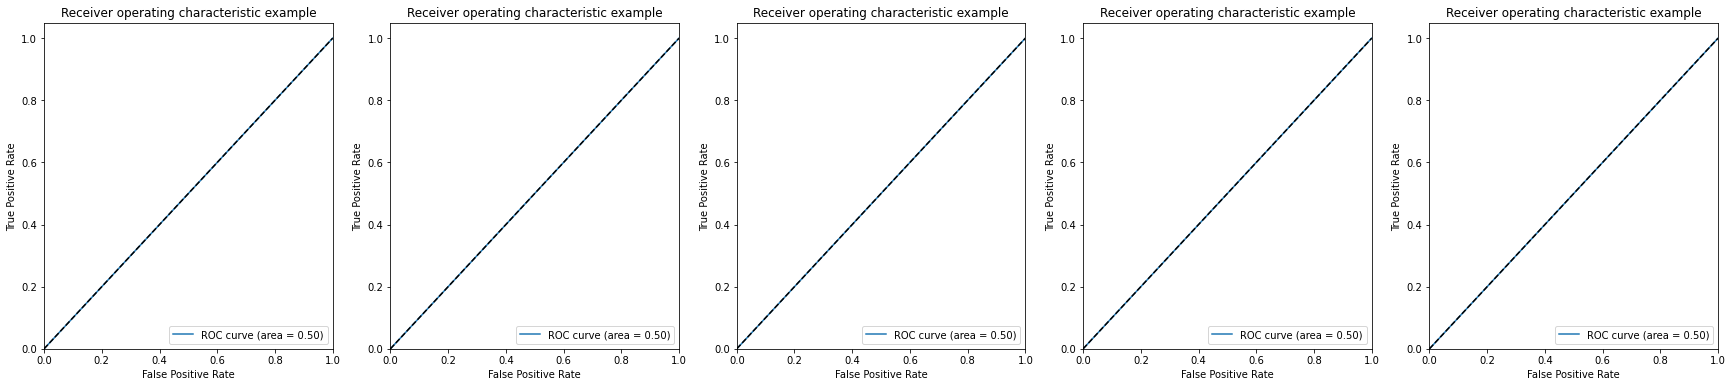

In [66]:
print_roc(y_test, y_pred_nb)

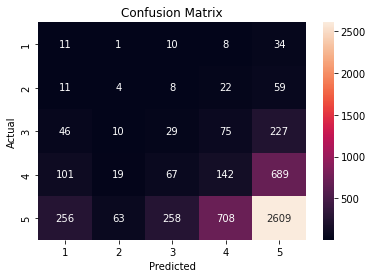

Accuracy is  0.5096030729833547
F1 Score is  0.19809935798231187
Precision is  0.2061337015639134
Recall is  0.1908282539168366
              precision    recall  f1-score   support

           0       0.04      0.03      0.04        64
           1       0.04      0.04      0.04       104
           2       0.08      0.07      0.08       387
           3       0.15      0.14      0.14      1018
           4       0.72      0.67      0.69      3894

   micro avg       0.55      0.51      0.53      5467
   macro avg       0.21      0.19      0.20      5467
weighted avg       0.55      0.51      0.53      5467
 samples avg       0.51      0.51      0.51      5467



c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc = dt.predict(X_test)
print_result(y_test, y_pred_rfc)

In [68]:
params = {"bootstrap": [True, False],
          "max_depth": [5, 6, 7, 8, 9, None],
          "max_features": ["auto", "sqrt"],
          "n_estimators": [100, 200, 300]
          }
grid = GridSearchCV(estimator=rfc, param_grid=params,
                    cv=10, scoring="f1_macro", return_train_score=False, verbose=True, n_jobs=-1)
grid.fit(X_validation, y_validation)
print(grid.best_params_)
print(grid.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
{'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}
0.20251700620424637


In [86]:
rfc.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

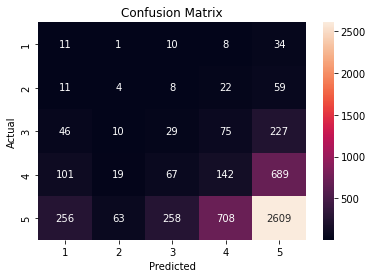

Accuracy is  0.5096030729833547
F1 Score is  0.19809935798231187
Precision is  0.2061337015639134
Recall is  0.1908282539168366
              precision    recall  f1-score   support

           0       0.04      0.03      0.04        64
           1       0.04      0.04      0.04       104
           2       0.08      0.07      0.08       387
           3       0.15      0.14      0.14      1018
           4       0.72      0.67      0.69      3894

   micro avg       0.55      0.51      0.53      5467
   macro avg       0.21      0.19      0.20      5467
weighted avg       0.55      0.51      0.53      5467
 samples avg       0.51      0.51      0.51      5467



c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
rfc = RandomForestClassifier(**grid.best_params_, random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc = dt.predict(X_test)
print_result(y_test, y_pred_rfc)

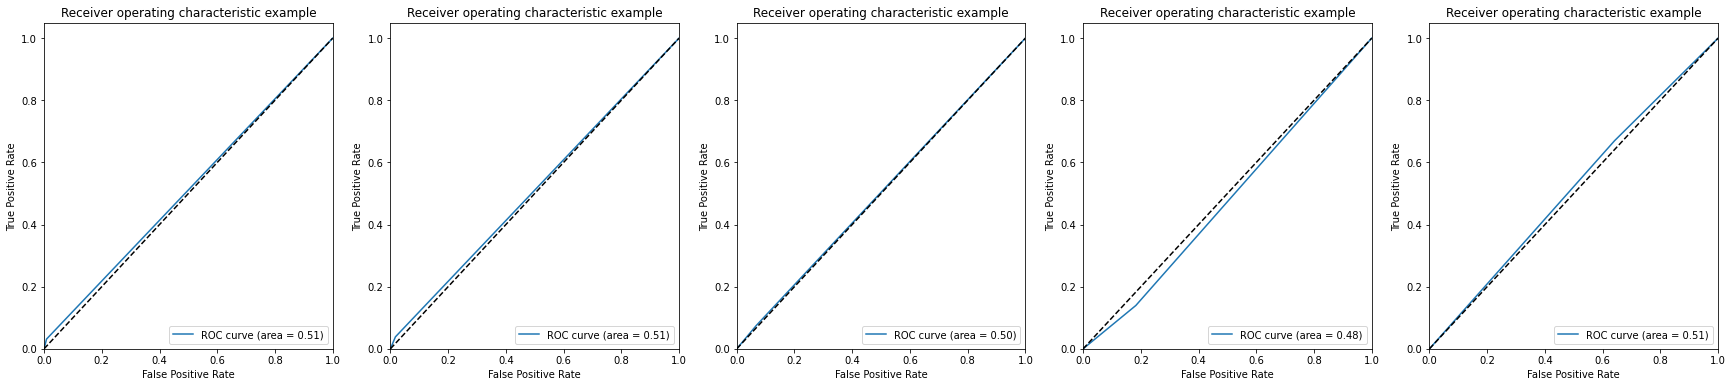

In [70]:
print_roc(y_test, y_pred_rfc)

<AxesSubplot:>

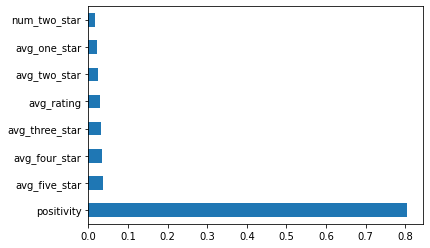

In [71]:
(pd.Series(rfc.feature_importances_, index=X_train.columns)
.nlargest(10)
   .plot(kind="barh")) 

In [72]:
scaler = StandardScaler()

X_train_standardized = scaler.fit_transform(X_train)
X_validation_standardized = scaler.fit_transform(X_validation)
X_test_standardized = scaler.fit_transform(X_test)

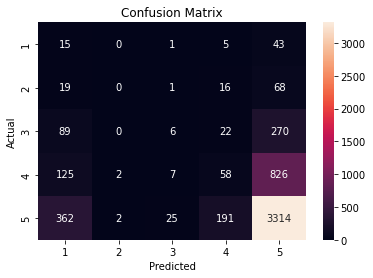

Accuracy is  0.6178891531004207
F1 Score is  0.18085875597399595
Precision is  0.2163307608633076
Recall is  0.18470624751886053
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.00      0.00      0.00       104
           2       0.15      0.02      0.03       387
           3       0.20      0.06      0.09      1018
           4       0.73      0.85      0.79      3894

   micro avg       0.70      0.62      0.65      5467
   macro avg       0.22      0.18      0.18      5467
weighted avg       0.57      0.62      0.58      5467
 samples avg       0.62      0.62      0.62      5467



c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

In [73]:
knn = KNeighborsClassifier()
knn.fit(X_train_standardized, y_train)
y_pred_knn = knn.predict(X_test_standardized)
print_result(y_test, y_pred_knn)

In [74]:
params = {"n_neighbors": range(1, 16)}
grid = GridSearchCV(estimator=knn,
                    param_grid=params,
                    cv=10,
                    scoring="f1_macro", return_train_score=False, verbose=0, n_jobs=-1)
grid.fit(X_validation_standardized, y_validation)
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 1}
0.2020496513470436


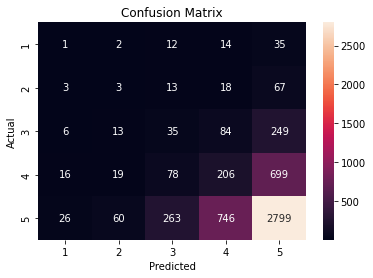

Accuracy is  0.5567953173586977
F1 Score is  0.21128147890813703
Precision is  0.21150523310807362
Recall is  0.2112132290368341
              precision    recall  f1-score   support

           0       0.02      0.02      0.02        64
           1       0.03      0.03      0.03       104
           2       0.09      0.09      0.09       387
           3       0.19      0.20      0.20      1018
           4       0.73      0.72      0.72      3894

   micro avg       0.56      0.56      0.56      5467
   macro avg       0.21      0.21      0.21      5467
weighted avg       0.56      0.56      0.56      5467
 samples avg       0.56      0.56      0.56      5467



In [75]:
knn = KNeighborsClassifier(**grid.best_params_)
knn.fit(X_train_standardized, y_train)
y_pred_knn = knn.predict(X_test_standardized)
print_result(y_test, y_pred_knn)

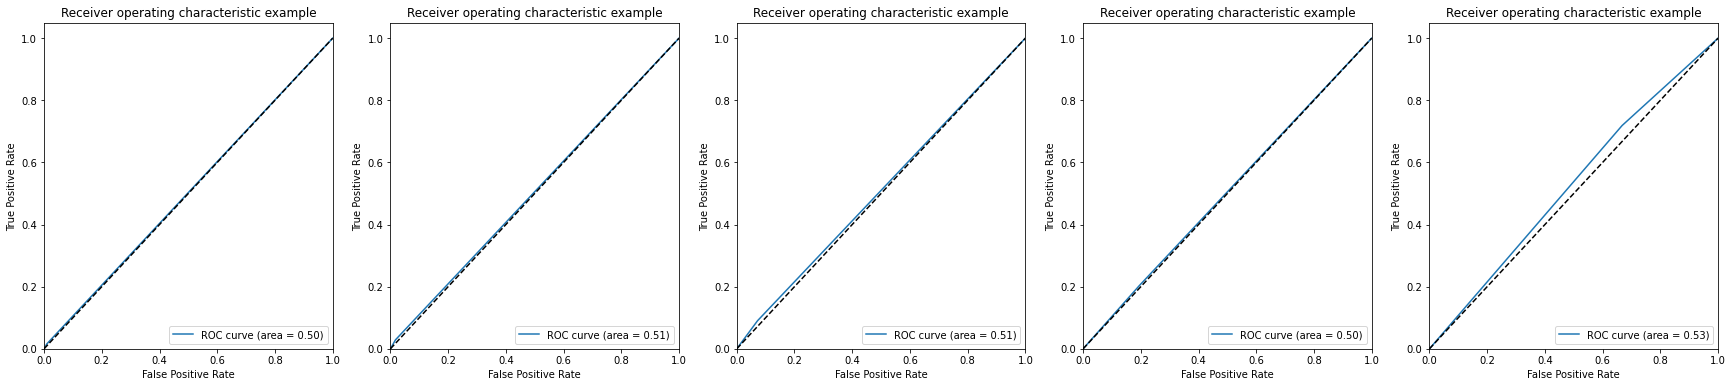

In [76]:
print_roc(y_test, y_pred_knn)

In [77]:
from keras.layers import Dense
from keras.models import Sequential

In [78]:
def build_model():
    model = Sequential()
    model.add(Dense(80, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train_standardized.shape[1]))
    model.add(Dense(40, kernel_initializer = 'uniform', activation='relu'))
    model.add(Dense(20, kernel_initializer = 'uniform', activation='sigmoid'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [79]:
model = build_model()
model.fit(X_train_standardized, y_train, epochs=50, batch_size=128)

Epoch 1/50
137/137 [==============================] - 1s 2ms/step - loss: 0.9566 - accuracy: 0.7124
Epoch 2/50
137/137 [==============================] - 0s 2ms/step - loss: 0.8371 - accuracy: 0.7124
Epoch 3/50
137/137 [==============================] - 0s 2ms/step - loss: 0.8332 - accuracy: 0.7124
Epoch 4/50
137/137 [==============================] - 0s 2ms/step - loss: 0.8301 - accuracy: 0.7124
Epoch 5/50
137/137 [==============================] - 0s 2ms/step - loss: 0.8274 - accuracy: 0.7124
Epoch 6/50
137/137 [==============================] - 0s 3ms/step - loss: 0.8264 - accuracy: 0.7124
Epoch 7/50
137/137 [==============================] - 0s 3ms/step - loss: 0.8254 - accuracy: 0.7124
Epoch 8/50
137/137 [==============================] - 0s 2ms/step - loss: 0.8246 - accuracy: 0.7124
Epoch 9/50
137/137 [==============================] - 0s 2ms/step - loss: 0.8243 - accuracy: 0.7124
Epoch 10/50
137/137 [==============================] - 0s 2ms/step - loss: 0.8240 - accuracy: 0.7124

171/171 [==============================] - 1s 2ms/step


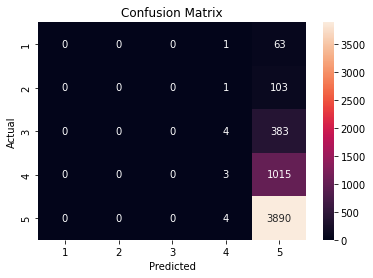

Accuracy is  0.7120907261752332
F1 Score is  0.16761663568445376
Precision is  0.1888014442469888
Recall is  0.20038394668943105
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.00      0.00      0.00       104
           2       0.00      0.00      0.00       387
           3       0.23      0.00      0.01      1018
           4       0.71      1.00      0.83      3894

   micro avg       0.71      0.71      0.71      5467
   macro avg       0.19      0.20      0.17      5467
weighted avg       0.55      0.71      0.59      5467
 samples avg       0.71      0.71      0.71      5467



c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
y_pred_ann = model.predict(X_test_standardized)
y_pred_ann = tf.one_hot(tf.argmax(y_pred_ann, axis = 1), depth = 5).numpy()
print_result(y_test, y_pred_ann)

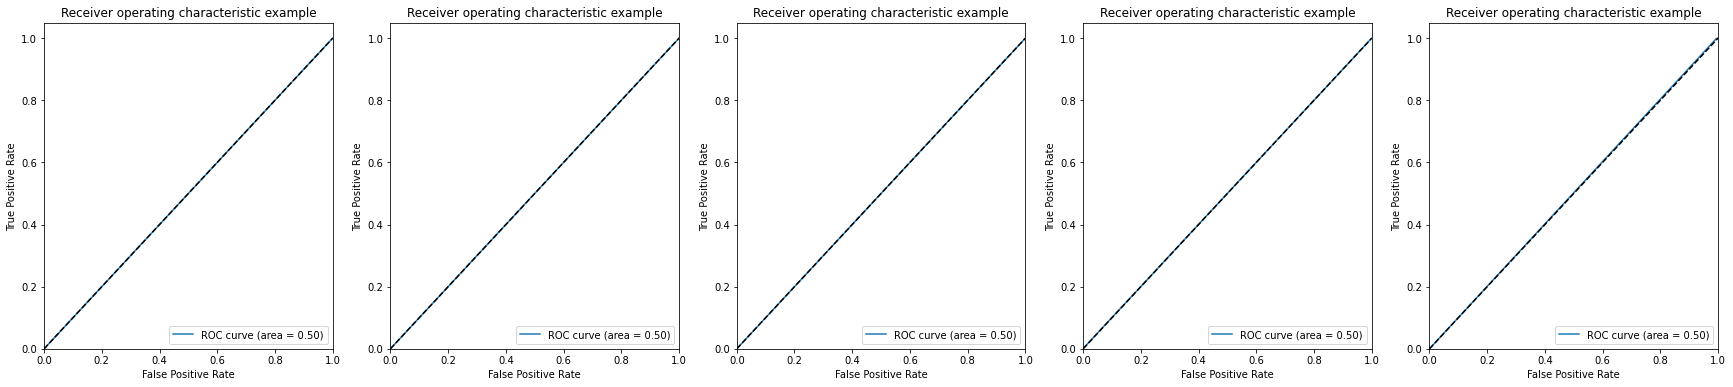

In [81]:
print_roc(y_test, y_pred_ann)